# Natural Language Preprocessing and Word Vectors

In this notebook, we clean up a dataset of natural language data (books from Project Gutenberg) and use word2vec to embed the language in word vectors.


#### Load dependencies

In [1]:
!pip install --upgrade numpy
!pip install --force-reinstall gensim

  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (

In [8]:
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
nltk.download('gutenberg')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

import string

#Restart runtime after running the pip install commands above
import gensim #import gensim after restarting the runtime
from gensim.models.phrases import Phraser, Phrases
from gensim.models.word2vec import Word2Vec

from sklearn.manifold import TSNE

import pandas as pd
from bokeh.io import output_notebook, output_file
from bokeh.plotting import show, figure
%matplotlib inline

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


#### Load Data

In [3]:
from nltk.corpus import gutenberg

In [4]:
len(gutenberg.fileids())

18

In [5]:
gutenberg.fileids()

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [6]:
len(gutenberg.words())

2621613

In [9]:
gberg_sent_tokens = sent_tokenize(gutenberg.raw())

In [10]:
gberg_sent_tokens[0:6]

['[Emma by Jane Austen 1816]\n\nVOLUME I\n\nCHAPTER I\n\n\nEmma Woodhouse, handsome, clever, and rich, with a comfortable home\nand happy disposition, seemed to unite some of the best blessings\nof existence; and had lived nearly twenty-one years in the world\nwith very little to distress or vex her.',
 "She was the youngest of the two daughters of a most affectionate,\nindulgent father; and had, in consequence of her sister's marriage,\nbeen mistress of his house from a very early period.",
 'Her mother\nhad died too long ago for her to have more than an indistinct\nremembrance of her caresses; and her place had been supplied\nby an excellent woman as governess, who had fallen little short\nof a mother in affection.',
 "Sixteen years had Miss Taylor been in Mr. Woodhouse's family,\nless as a governess than a friend, very fond of both daughters,\nbut particularly of Emma.",
 'Between _them_ it was more the intimacy\nof sisters.',
 "Even before Miss Taylor had ceased to hold the nominal

In [11]:
gberg_sent_tokens[1]

"She was the youngest of the two daughters of a most affectionate,\nindulgent father; and had, in consequence of her sister's marriage,\nbeen mistress of his house from a very early period."

In [12]:
word_tokenize(gberg_sent_tokens[1])

['She',
 'was',
 'the',
 'youngest',
 'of',
 'the',
 'two',
 'daughters',
 'of',
 'a',
 'most',
 'affectionate',
 ',',
 'indulgent',
 'father',
 ';',
 'and',
 'had',
 ',',
 'in',
 'consequence',
 'of',
 'her',
 'sister',
 "'s",
 'marriage',
 ',',
 'been',
 'mistress',
 'of',
 'his',
 'house',
 'from',
 'a',
 'very',
 'early',
 'period',
 '.']

In [13]:
word_tokenize(gberg_sent_tokens[1])[14]

'father'

In [14]:
# a convenient method that handles newlines, as well as tokenizing sentences and words in one shot
gberg_sents = gutenberg.sents()

In [15]:
gberg_sents[0:6]

[['[', 'Emma', 'by', 'Jane', 'Austen', '1816', ']'],
 ['VOLUME', 'I'],
 ['CHAPTER', 'I'],
 ['Emma',
  'Woodhouse',
  ',',
  'handsome',
  ',',
  'clever',
  ',',
  'and',
  'rich',
  ',',
  'with',
  'a',
  'comfortable',
  'home',
  'and',
  'happy',
  'disposition',
  ',',
  'seemed',
  'to',
  'unite',
  'some',
  'of',
  'the',
  'best',
  'blessings',
  'of',
  'existence',
  ';',
  'and',
  'had',
  'lived',
  'nearly',
  'twenty',
  '-',
  'one',
  'years',
  'in',
  'the',
  'world',
  'with',
  'very',
  'little',
  'to',
  'distress',
  'or',
  'vex',
  'her',
  '.'],
 ['She',
  'was',
  'the',
  'youngest',
  'of',
  'the',
  'two',
  'daughters',
  'of',
  'a',
  'most',
  'affectionate',
  ',',
  'indulgent',
  'father',
  ';',
  'and',
  'had',
  ',',
  'in',
  'consequence',
  'of',
  'her',
  'sister',
  "'",
  's',
  'marriage',
  ',',
  'been',
  'mistress',
  'of',
  'his',
  'house',
  'from',
  'a',
  'very',
  'early',
  'period',
  '.'],
 ['Her',
  'mother',
  'h

In [16]:
gberg_sents[4][14]

'father'

#### Iteratively preprocess a sentence

##### a tokenized sentence:

In [18]:
gberg_sents[4]

['She',
 'was',
 'the',
 'youngest',
 'of',
 'the',
 'two',
 'daughters',
 'of',
 'a',
 'most',
 'affectionate',
 ',',
 'indulgent',
 'father',
 ';',
 'and',
 'had',
 ',',
 'in',
 'consequence',
 'of',
 'her',
 'sister',
 "'",
 's',
 'marriage',
 ',',
 'been',
 'mistress',
 'of',
 'his',
 'house',
 'from',
 'a',
 'very',
 'early',
 'period',
 '.']

##### to lowercase:

In [19]:
[w.lower() for w in gberg_sents[4]]

['she',
 'was',
 'the',
 'youngest',
 'of',
 'the',
 'two',
 'daughters',
 'of',
 'a',
 'most',
 'affectionate',
 ',',
 'indulgent',
 'father',
 ';',
 'and',
 'had',
 ',',
 'in',
 'consequence',
 'of',
 'her',
 'sister',
 "'",
 's',
 'marriage',
 ',',
 'been',
 'mistress',
 'of',
 'his',
 'house',
 'from',
 'a',
 'very',
 'early',
 'period',
 '.']

##### remove stopwords and punctuation:

In [20]:
stpwrds = stopwords.words('english') + list(string.punctuation)

In [21]:
stpwrds

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 'her',
 'here',
 'hers',
 'herself',
 "he's",
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 'if',
 "i'll",
 "i'm",
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 "i've",
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [22]:
[w.lower() for w in gberg_sents[4] if w.lower() not in stpwrds]

['youngest',
 'two',
 'daughters',
 'affectionate',
 'indulgent',
 'father',
 'consequence',
 'sister',
 'marriage',
 'mistress',
 'house',
 'early',
 'period']

##### stem words:

In [23]:
stemmer = PorterStemmer()

In [24]:
[stemmer.stem(w.lower()) for w in gberg_sents[4]
 if w.lower() not in stpwrds]

['youngest',
 'two',
 'daughter',
 'affection',
 'indulg',
 'father',
 'consequ',
 'sister',
 'marriag',
 'mistress',
 'hous',
 'earli',
 'period']

##### handle bigram collocations:

In [25]:
phrases = Phrases(gberg_sents) # train detector

In [26]:
bigram = Phraser(phrases) # create a more efficient Phraser object for transforming sentences

In [27]:
bigram.phrasegrams # output count and score of each bigram

{'two_daughters': 11.966813731181547,
 'her_sister': 17.7960829227865,
 "'_s": 31.066242737744524,
 'very_early': 11.01214147275924,
 'Her_mother': 13.529425062715127,
 'long_ago': 63.22343628984789,
 'more_than': 29.023584433996874,
 'had_been': 22.306024648925288,
 'an_excellent': 39.063874851750626,
 'Miss_Taylor': 453.75918026073305,
 'very_fond': 24.134280468850747,
 'passed_away': 12.35053642325912,
 'too_much': 31.376002029426687,
 'did_not': 11.72841621714281,
 'any_means': 14.096964108090186,
 'wedding_-': 17.4695197740113,
 'Her_father': 13.129571562488772,
 'after_dinner': 21.528548116881705,
 'self_-': 47.79018053120332,
 'sixteen_years': 107.0461671612265,
 'five_years': 40.128755673408115,
 'years_old': 54.735425236061104,
 'seven_years': 52.59411150244507,
 'each_other': 79.4168405322873,
 'a_mile': 12.783091600264584,
 'must_be': 10.229989650632808,
 'difference_between': 220.52537305244678,
 'could_not': 10.870983286982371,
 'having_been': 11.53801833156938,
 'miles_of

In [28]:
tokenized_sentence = "Jon lives in New York City".split()

In [29]:
tokenized_sentence

['Jon', 'lives', 'in', 'New', 'York', 'City']

In [30]:
bigram[tokenized_sentence]

['Jon', 'lives', 'in', 'New_York', 'City']

#### Preprocess the corpus

In [31]:
# as in Maas et al. (2001):
# - leave in stop words ("indicative of sentiment")
# - no stemming ("model learns similar representations of words of the same stem when data suggests it")
lower_sents = []
for s in gberg_sents:
    lower_sents.append([w.lower() for w in s if w.lower()
                        not in list(string.punctuation)])

In [32]:
lower_sents[0:5]

[['emma', 'by', 'jane', 'austen', '1816'],
 ['volume', 'i'],
 ['chapter', 'i'],
 ['emma',
  'woodhouse',
  'handsome',
  'clever',
  'and',
  'rich',
  'with',
  'a',
  'comfortable',
  'home',
  'and',
  'happy',
  'disposition',
  'seemed',
  'to',
  'unite',
  'some',
  'of',
  'the',
  'best',
  'blessings',
  'of',
  'existence',
  'and',
  'had',
  'lived',
  'nearly',
  'twenty',
  'one',
  'years',
  'in',
  'the',
  'world',
  'with',
  'very',
  'little',
  'to',
  'distress',
  'or',
  'vex',
  'her'],
 ['she',
  'was',
  'the',
  'youngest',
  'of',
  'the',
  'two',
  'daughters',
  'of',
  'a',
  'most',
  'affectionate',
  'indulgent',
  'father',
  'and',
  'had',
  'in',
  'consequence',
  'of',
  'her',
  'sister',
  's',
  'marriage',
  'been',
  'mistress',
  'of',
  'his',
  'house',
  'from',
  'a',
  'very',
  'early',
  'period']]

In [33]:
lower_bigram = Phraser(Phrases(lower_sents))

In [34]:
lower_bigram.phrasegrams # miss taylor, mr woodhouse, mr weston

{'two_daughters': 11.080802900992637,
 'her_sister': 16.93971298099339,
 'very_early': 10.516998773665177,
 'her_mother': 10.70812618607742,
 'long_ago': 59.22644201533601,
 'more_than': 28.529926612065935,
 'had_been': 21.583193129694834,
 'an_excellent': 37.41859680854167,
 'sixteen_years': 131.42913000977518,
 'miss_taylor': 420.4340982546865,
 'mr_woodhouse': 104.19907841850323,
 'very_fond': 24.185726346489627,
 'passed_away': 11.751473221742694,
 'too_much': 30.363090173835406,
 'did_not': 10.846196223896685,
 'any_means': 14.294148100212627,
 'after_dinner': 18.60737125272944,
 'mr_weston': 91.63290824201266,
 'five_years': 37.66428596665674,
 'years_old': 48.59909444619029,
 'seven_years': 50.3345604292756,
 'each_other': 71.31277029783762,
 'well_informed': 14.185028016786626,
 'a_mile': 11.700110753652233,
 'difference_between': 207.86784241868986,
 'mrs_weston': 180.6778969011602,
 'could_not': 10.213333164207082,
 'having_been': 10.723750443105281,
 'sixteen_miles': 105.040

In [35]:
lower_bigram["jon lives in new york city".split()]

['jon', 'lives', 'in', 'new_york', 'city']

In [36]:
lower_bigram = Phraser(Phrases(lower_sents,
                               min_count=32, threshold=64))
lower_bigram.phrasegrams

{'miss_taylor': 156.44059469941823,
 'mr_woodhouse': 82.04651843976633,
 'mr_weston': 75.87438262077481,
 'mrs_weston': 160.6848509325892,
 'great_deal': 93.36368125424357,
 'mr_knightley': 161.74131790625913,
 'miss_woodhouse': 229.03802722366902,
 'years_ago': 74.31594785893046,
 'mr_elton': 121.3990121932397,
 'dare_say': 89.94000515807346,
 'frank_churchill': 1316.4456593286038,
 'miss_bates': 276.3958829169252,
 'drawing_room': 84.91494947493561,
 'mrs_goddard': 143.57843432545658,
 'miss_smith': 73.03442128232508,
 'few_minutes': 204.16834974753786,
 'john_knightley': 83.03755747111268,
 'don_t': 250.30957446808512,
 'good_natured': 88.69936184891343,
 'few_moments': 107.77584531675087,
 'thousand_pounds': 166.51834523092802,
 'o_clock': 89.14789088153574,
 'jane_fairfax': 654.556591758761,
 'miss_fairfax': 196.19987447261062,
 'ma_am': 157.25846601094193,
 'mrs_elton': 93.08931456265867,
 'forty_years': 90.60220877269607,
 'cut_off': 129.60290535032792,
 'ten_thousand': 84.00099

In [37]:
clean_sents = []
for s in lower_sents:
    clean_sents.append(lower_bigram[s])

In [38]:
clean_sents[0:9]

[['emma', 'by', 'jane', 'austen', '1816'],
 ['volume', 'i'],
 ['chapter', 'i'],
 ['emma',
  'woodhouse',
  'handsome',
  'clever',
  'and',
  'rich',
  'with',
  'a',
  'comfortable',
  'home',
  'and',
  'happy',
  'disposition',
  'seemed',
  'to',
  'unite',
  'some',
  'of',
  'the',
  'best',
  'blessings',
  'of',
  'existence',
  'and',
  'had',
  'lived',
  'nearly',
  'twenty',
  'one',
  'years',
  'in',
  'the',
  'world',
  'with',
  'very',
  'little',
  'to',
  'distress',
  'or',
  'vex',
  'her'],
 ['she',
  'was',
  'the',
  'youngest',
  'of',
  'the',
  'two',
  'daughters',
  'of',
  'a',
  'most',
  'affectionate',
  'indulgent',
  'father',
  'and',
  'had',
  'in',
  'consequence',
  'of',
  'her',
  'sister',
  's',
  'marriage',
  'been',
  'mistress',
  'of',
  'his',
  'house',
  'from',
  'a',
  'very',
  'early',
  'period'],
 ['her',
  'mother',
  'had',
  'died',
  'too',
  'long',
  'ago',
  'for',
  'her',
  'to',
  'have',
  'more',
  'than',
  'an',
 

In [39]:
clean_sents[6]

['sixteen',
 'years',
 'had',
 'miss_taylor',
 'been',
 'in',
 'mr_woodhouse',
 's',
 'family',
 'less',
 'as',
 'a',
 'governess',
 'than',
 'a',
 'friend',
 'very',
 'fond',
 'of',
 'both',
 'daughters',
 'but',
 'particularly',
 'of',
 'emma']

#### Run word2vec

In [40]:
# max_vocab_size can be used instead of min_count (which has increased here)
# model = Word2Vec(sentences=clean_sents, size=64,
#                  sg=1, window=10, iter=5,
#                  min_count=10, workers=4)
# model.save('clean_gutenberg_model.w2v')

#### Explore model

In [45]:
# max_vocab_size can be used instead of min_count (which has increased here)
model = Word2Vec(sentences=clean_sents, vector_size=64,
                 sg=1, window=10, epochs=5,
                 min_count=10, workers=4)
model.save('clean_gutenberg_model.w2v') #This line saves the model. Make sure it is executed to create the file

In [47]:
len(model.wv.key_to_index) # would be 17k if we carried out no preprocessing


10329

In [48]:
model.wv['dog']

array([-0.20605828, -0.5038475 ,  0.25036258, -0.016671  ,  0.477672  ,
       -0.20936291,  0.27586713, -0.02942813, -0.3486828 ,  0.17831543,
       -0.0217765 , -0.11919972, -0.03447083,  0.21595846,  0.23259377,
       -0.47702575,  0.26884803,  0.18804345, -0.21249789, -0.22722137,
        0.13305937,  0.45010158,  0.0684511 , -0.3528313 , -0.21486   ,
        0.6900236 , -0.34923935,  0.20440933, -0.08471461, -0.898501  ,
       -0.00141754,  0.02378793, -0.04449517,  0.00394745,  0.20300382,
       -0.19284272, -0.0604291 , -0.5705838 ,  0.28480634,  0.30921295,
        0.01450792, -0.15779604,  0.03240718, -0.34635282,  0.01855781,
        0.13310318, -0.15193066,  0.19580224,  0.03450728,  0.55258244,
       -0.16649307,  0.53973633,  0.08273949,  0.1367799 ,  0.42216402,
        0.05764264, -0.441026  ,  0.19766133, -0.10728123,  0.06714564,
        0.19067094, -0.25859576, -0.389675  , -0.17147514], dtype=float32)

In [49]:
len(model.wv['dog'])

64

In [50]:
model.wv.most_similar('dog', topn=3)

[('cage', 0.768855094909668),
 ('butcher', 0.7658955454826355),
 ('puppy', 0.7626519203186035)]

In [51]:
model.wv.most_similar('eat', topn=3)

[('bread', 0.8612912893295288),
 ('drink', 0.811890184879303),
 ('meat', 0.7826777100563049)]

In [52]:
model.wv.most_similar('day', topn=3)

[('morning', 0.7810055017471313),
 ('evening', 0.7571168541908264),
 ('night', 0.7537798881530762)]

In [53]:
model.wv.most_similar('father', topn=3)

[('mother', 0.813225269317627),
 ('brother', 0.7339302897453308),
 ('sister', 0.7235724329948425)]

In [54]:
model.wv.most_similar('ma_am', topn=3)

[('betty', 0.857221245765686),
 ('m_sure', 0.8430845141410828),
 ('mamma', 0.8328694701194763)]

In [55]:
model.wv.doesnt_match("mother father sister brother dog".split())

'dog'

In [56]:
model.wv.similarity('father', 'dog')

0.5099798

In [57]:
model.wv.most_similar(positive=['father', 'woman'], negative=['man'])

[('mother', 0.7519389390945435),
 ('sister', 0.745190441608429),
 ('husband', 0.7410882115364075),
 ('daughter', 0.7171592116355896),
 ('wife', 0.7044057846069336),
 ('daughters', 0.67827308177948),
 ('sarah', 0.6662634611129761),
 ('child', 0.6605930924415588),
 ('conceived', 0.6585602164268494),
 ('womb', 0.6532605886459351)]

In [58]:
model.wv.most_similar(positive=['husband', 'woman'], negative=['man'])

[('wife', 0.6931145787239075),
 ('sister', 0.6836009621620178),
 ('child', 0.6558042168617249),
 ('daughter', 0.6542418003082275),
 ('maid', 0.6444730162620544),
 ('conceived', 0.6442225575447083),
 ('mother', 0.63508540391922),
 ('nurse', 0.632928192615509),
 ('harlot', 0.6242380142211914),
 ('married', 0.6198844313621521)]

#### Reduce word vector dimensionality with t-SNE

In [65]:
tsne = TSNE(n_components=2, n_iter=1000)

In [67]:
X_2d = tsne.fit_transform(model.wv.vectors) # Use model.wv.vectors to get the word vectors

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7c8ec6f22840>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __i

In [69]:
coords_df = pd.DataFrame(X_2d, columns=['x','y'])
coords_df['token'] = list(model.wv.key_to_index.keys()) # Use key_to_index instead of vocab

In [70]:
coords_df.head()

,x,y,token
0,29.441570,-49.966000,the
1,29.557583,-49.873585,and
2,29.260105,-50.006508,of
3,30.050764,-49.605019,to
4,27.793829,-32.327412,a


In [71]:
coords_df.to_csv('clean_gutenberg_tsne.csv', index=False)

#### Visualise

In [72]:
coords_df = pd.read_csv('clean_gutenberg_tsne.csv')

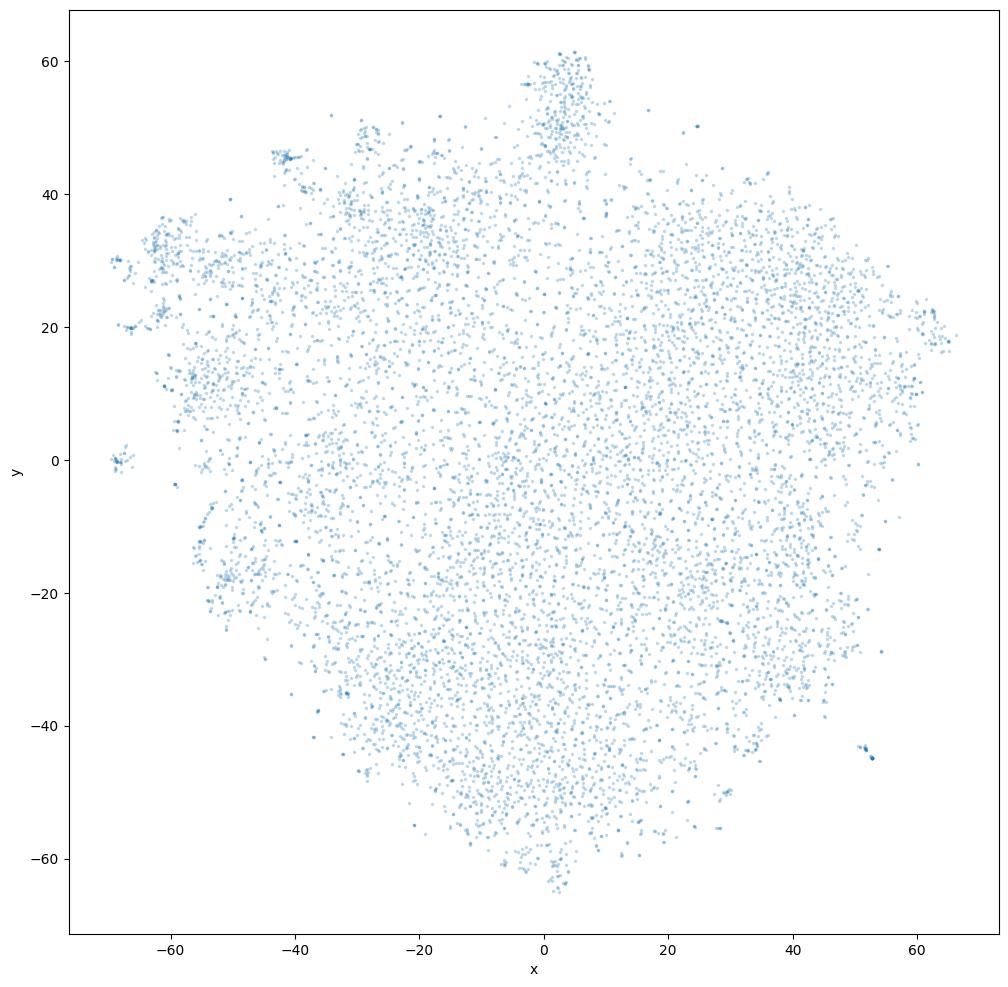

In [73]:
_ = coords_df.plot.scatter('x', 'y', figsize=(12,12),
                           marker='.', s=10, alpha=0.2)

In [74]:
output_notebook()

In [75]:
subset_df = coords_df.sample(n=5000)

In [77]:
p = figure(width=800, height=800) # Changed plot_width and plot_height to width and height respectively
_ = p.text(x=subset_df.x, y=subset_df.y, text=subset_df.token)

In [78]:
show(p)

In [80]:
#output_file() here